In [7]:
!pip install rebound


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [8]:
import rebound
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

In [45]:
def integrate_to_mean_anomaly_16pi(sim, body_index):
    target_mean_anomaly = 16 * np.pi
    initial_time_step = 0.02
    time_step = initial_time_step
    M=[0]
    time=[sim.t]
    current_mean_anomaly = 0
    N_peri=0
    while True:
        sim.integrate(sim.t + time_step)
        current_mean_anomaly = sim.particles[1].M +N_peri*np.pi
        if current_mean_anomaly  - M[len(M)-1] < 0:
          N_peri = N_peri+ 2
          current_mean_anomaly = current_mean_anomaly +2*np.pi
          time.append(sim.t)
          M.append(sim.particles[1].M+ N_peri*np.pi)
        else:
          time.append(sim.t)
          M.append(sim.particles[1].M+ N_peri*np.pi)
          
        if current_mean_anomaly  > target_mean_anomaly:
          f = CubicSpline(M, time)
          sim.integrate(f(target_mean_anomaly))
          break

In [62]:
def optimizing_function(theta):
  initial_e_1,initial_e_2, initial_e_3,initial_e_4,mean_anomaly_2, mean_anomaly_3,mean_anomaly_4, X_5,X_6,pomega_2, pomega_3, pomega_4 =theta
  pomega_1 =0
  kappa=2.035
  rho = 1
  ini_param = [initial_e_1,initial_e_2, initial_e_3,initial_e_4,mean_anomaly_2, mean_anomaly_3,mean_anomaly_4, X_5,X_6, pomega_2, pomega_3, pomega_4]
  C_0 = 0.5
  C_1 = 0.5
  mean_anomaly_1 = 0
  a_1=  rho*1
  a_2=  a_1*kappa**(2/3)
  pd_pc_nom = (1+C_0*(1-kappa))**(-1)
  pe_pd_nom = (1+C_1*(1-pd_pc_nom))**(-1)
 
  a_3=  a_2*(X_5+pd_pc_nom)**(2/3)
  a_4=  a_3*(X_6+pe_pd_nom)**(2/3)

  
  sim = rebound.Simulation()
  sim.add(m=2)
  sim.add(m=3e-5, a=a_1, e=initial_e_1, M=mean_anomaly_1, pomega=pomega_1)
  sim.add(m=5e-5, a=a_2, e=initial_e_2, M=mean_anomaly_2, pomega=pomega_2)
  sim.add(m=7e-5, a=a_3, e=initial_e_3, M=mean_anomaly_3, pomega=pomega_3)
  sim.add(m=9e-4, a=a_4, e=initial_e_4, M=mean_anomaly_4, pomega=pomega_4)
  sim.move_to_com()

  integrate_to_mean_anomaly_16pi(sim, 1)


  sim.move_to_com()


  end_param = [sim.particles[1].e,sim.particles[2].e,sim.particles[3].e,sim.particles[4].e, sim.particles[2].M,sim.particles[3].M,sim.particles[4].M, (sim.particles[3].a)**(3/2)/(sim.particles[2].a)**(3/2) - pd_pc_nom, (sim.particles[4].a)**(3/2)/(sim.particles[3].a)**(3/2) - pe_pd_nom, sim.particles[1].pomega,sim.particles[2].pomega, sim.particles[3].pomega,  sim.particles[4].pomega]
  difference =[]
  

  for i in range(0,8):
    difference.append(ini_param[i]-end_param[i])
  difference.append((pomega_1-ini_param[9])-(end_param[9]-end_param[10]))
  difference.append((ini_param[9]-ini_param[10])-(end_param[10]-end_param[11]))
  difference.append((ini_param[10]-ini_param[11])-(end_param[11]-end_param[12]))

  return np.sqrt(difference[0]**2+difference[1]**2+difference[2]**2+difference[3]**2+difference[4]**2+difference[5]**2+difference[6]**2+difference[7]**2+difference[8]**2+difference[9]**2+difference[10]**2)
  

In [63]:
ini_guess=[ 0.03,0.05,0.05,0.08, 1 ,0.5,0.5, 0.01 , 0.01,  1,1,1]

bounds = [ (0, 0.99),(0, 0.99),(0, 0.99),(0, 0.99), (None, None), (None, None), (None, None),  (-.5, .5), (-.5, .5),  (None, None), (None, None), (None, None)]
result = minimize(optimizing_function, ini_guess, bounds=bounds, tol=1e-6)

In [64]:
print(result.x)

[ 2.74232758e-01  8.18687387e-01  5.67820900e-01  5.81138501e-02
  9.17489880e-01  4.82999517e-01  3.47675095e-01 -6.24625847e-04
  1.61905447e-03  1.05840082e+00  1.03243636e+00  8.65807475e-01]


In [70]:
kappa_list=[2]
e_list=[]
e_list.append(result.x[:4])
print(e_list)

[array([0.27423276, 0.81868739, 0.5678209 , 0.05811385])]


In [65]:
initial_e_1,initial_e_2, initial_e_3,initial_e_4,mean_anomaly_2, mean_anomaly_3,mean_anomaly_4, X_5,X_6,pomega_2, pomega_3, pomega_4 =(result.x)

C_0 = 0.5
C_1 = 0.5
mean_anomaly_1 = 0
rho=1
kappa = 2
a_1=  rho*1
a_2=  a_1*kappa**(2/3)
pd_pc_nom = (1+C_0*(1-kappa))**(-1)
pe_pd_nom = (1+C_1*(1-pd_pc_nom))**(-1)
a_3=  a_2*(X_5+pd_pc_nom)**(2/3)
a_4=  a_3*(X_6+pe_pd_nom)**(2/3)

print(a_1,a_2,a_3,a_4)

1 1.5874010519681994 2.5193174196415953 4.00132512088794


In [61]:
2.9240177382128656**(3/2)

4.999999999999999

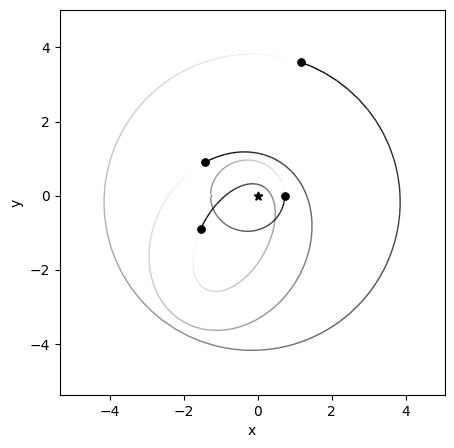

In [66]:
initial_e_1,initial_e_2, initial_e_3,initial_e_4,mean_anomaly_2, mean_anomaly_3,mean_anomaly_4, X_5,X_6,pomega_2, pomega_3, pomega_4 =(result.x)

sim = rebound.Simulation()
pomega_1=0
C_0 = 0.5
C_1 = 0.5
mean_anomaly_1 = 0
a_1=  rho*1
a_2=  a_1*kappa**(2/3)
pd_pc_nom = (1+C_0*(1-kappa))**(-1)
pe_pd_nom = (1+C_1*(1-pd_pc_nom))**(-1)
 
a_3=  a_2*(X_5+pd_pc_nom)**(2/3)
a_4=  a_3*(X_6+pe_pd_nom)**(2/3)

sim.add(m=2)
sim.add(m=3e-5, a=a_1, e=initial_e_1, M=mean_anomaly_1, pomega=pomega_1)
sim.add(m=5e-5, a=a_2, e=initial_e_2, M=mean_anomaly_2, pomega=pomega_2)
sim.add(m=7e-5, a=a_3, e=initial_e_3, M=mean_anomaly_3, pomega=pomega_3)
sim.add(m=9e-4, a=a_4, e=initial_e_4, M=mean_anomaly_4, pomega=pomega_4)

sim.move_to_com()

rebound.OrbitPlot(sim)

4.44308444039416


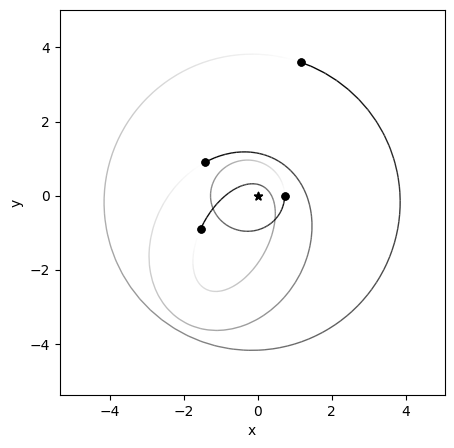

In [67]:
initial_e_1,initial_e_2, initial_e_3,initial_e_4,mean_anomaly_2, mean_anomaly_3,mean_anomaly_4, X_5,X_6,pomega_2, pomega_3, pomega_4 =(result.x)

sim = rebound.Simulation()

C_0 = 0.5
C_1 = 0.5
mean_anomaly_1 = 0
a_1=  rho*1
a_2=  a_1*kappa**(2/3)
pd_pc_nom = (1+C_0*(1-kappa))**(-1)
pe_pd_nom = (1+C_1*(1-pd_pc_nom))**(-1)
 
a_3=  a_2*(X_5+pd_pc_nom)**(2/3)
a_4=  a_3*(X_6+pe_pd_nom)**(2/3)

sim.add(m=2)
sim.add(m=3e-5, a=a_1, e=initial_e_1, M=mean_anomaly_1, pomega=pomega_1)
sim.add(m=5e-5, a=a_2, e=initial_e_2, M=mean_anomaly_2, pomega=pomega_2)
sim.add(m=7e-5, a=a_3, e=initial_e_3, M=mean_anomaly_3, pomega=pomega_3)
sim.add(m=9e-4, a=a_4, e=initial_e_4, M=mean_anomaly_4, pomega=pomega_4)
sim.move_to_com()
integrate_to_mean_anomaly_16pi(sim, 1)
rebound.OrbitPlot(sim)
print(sim.particles[1].P)

In [68]:
sim = rebound.Simulation()
sim.add(m=2)
sim.add(m=3e-5, a=a_1, e=initial_e_1, M=mean_anomaly_1, pomega=0)
sim.add(m=5e-5, a=a_2, e=initial_e_2, M=mean_anomaly_2, pomega=pomega_2)
sim.add(m=7e-5, a=a_3, e=initial_e_3, M=mean_anomaly_3, pomega=pomega_3)
sim.add(m=9e-4, a=a_4, e=initial_e_4, M=mean_anomaly_4, pomega=pomega_4)
sim.move_to_com()
ab_cart_initial= [sim.particles[1].x- sim.particles[2].x, sim.particles[1].y-sim.particles[2].y]
bc_cart_initial= [sim.particles[2].x-sim.particles[3].x, sim.particles[2].y- sim.particles[3].y]
cd_cart_initial= [sim.particles[3].x- sim.particles[4].x, sim.particles[3].y-sim.particles[4].y]

integrate_to_mean_anomaly_16pi(sim, 1)
sim.move_to_com()
ab_cart_final= [sim.particles[1].x- sim.particles[2].x, sim.particles[1].y-sim.particles[2].y]
bc_cart_final= [sim.particles[2].x-sim.particles[3].x, sim.particles[2].y- sim.particles[3].y]
cd_cart_final= [sim.particles[3].x-sim.particles[4].x, sim.particles[3].y- sim.particles[4].y]




print(sum((x - y) ** 2 for x, y in zip(ab_cart_initial, ab_cart_final)))
print(sum((x - y) ** 2 for x, y in zip(bc_cart_initial, bc_cart_final)))
print(sum((x - y) ** 2 for x, y in zip(cd_cart_initial, cd_cart_final)))


6.838709851113629e-07
6.11172679172604e-07
1.1138893017205625e-05


In [32]:
N= 1000
transittimes = np.zeros(N)
p = sim.particles
i = 0
while i<N:
    y_old = p[1].y - p[0].y
    t_old = sim.t
    sim.integrate(sim.t+0.5)
    t_new = sim.t
    if y_old*(p[1].y-p[0].y)<0. and p[1].x-p[0].x>0.:
        while t_new-t_old>1e-7:
            if y_old*(p[1].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t+0.05)


In [ ]:
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes, rcond=-1)[0]

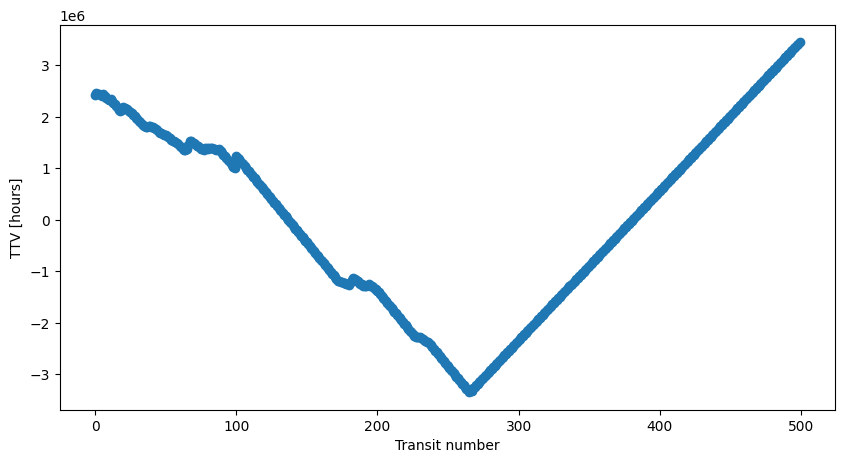

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)

ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")
plt.scatter(range(N), (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi));

In [22]:
!pip install ttvfaster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 118.5 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-3.0.10-py2.py3-none-any.whl (1.2 MB)
  Created wheel for ttvfaster: filename=ttvfaster-0.1.0-cp39-cp39-macosx_13_0_arm64.whl size=38902 sha256=adf6780a751596dd3a18b869636438ae1ad05fa30177a6c02a355ed7e98bb858
  Stored in directory: /Users/hurum/Library/Caches/pip/wheels/4f/7c/73/ba6b355ced124003a57f2cb2e62fcf4ed36b74bd3f59d521da
Successfully built ttvfaster

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [23]:
from ttvfaster import run_ttvfaster